In [1]:
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from random import shuffle, choices
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    hamming_loss,
)

from GRU_pipeline import DataHolder, paths, MultiModalDicDataset, GRUModel, pad_collate, eval_on_val, train_one_epoch, BertClassif
from models import GRUMultiModal, GRUBiModal

/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'MultiModalDicDataset' from 'GRU_pipeline' (/Users/ewenmichel/Desktop/Centrale/3A/SDI/Project/Multimodal-CSC/GRU_pipeline.py)

In [ ]:
DH = DataHolder(**paths, none_as_class=True)

train_test_1 = DH.stratified_train_test_split(feature = 'multimodal', speaker = 1, none_prop = .5, test_size = .15, val_size = .17)
train_test_2 = DH.stratified_train_test_split(feature = 'multimodal', speaker = 2, none_prop = .5, test_size = .15, val_size = .17)

class_weights = train_test_1['class_weights']
class_weights = torch.Tensor([(1 - x) for x in class_weights])

train_dataset_1 = MultiModalDicDataset(**train_test_1['data'])
test_dataset_1 = MultiModalDicDataset(train_dic_openface = train_test_1["data"]["test_dic_openface"], train_dic_opensmile = train_test_1["data"]["test_dic_opensmile"], features_openface = train_test_1["data"]["features_openface"], features_opensmile = train_test_1["data"]["features_opensmile"], embeds = train_test_1["data"]["embeds"], targets = train_test_1["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)
val_dataset_1 = MultiModalDicDataset(train_dic_openface = train_test_1["data"]["valid_dic_openface"], train_dic_opensmile = train_test_1["data"]["valid_dic_opensmile"], features_openface = train_test_1["data"]["features_openface"], features_opensmile = train_test_1["data"]["features_opensmile"], embeds = train_test_1["data"]["embeds"], targets = train_test_1["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)

train_loader_1 = DataLoader(train_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)
val_loader_1 = DataLoader(val_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)
test_loader_1 = DataLoader(test_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)

train_dataset_2 = MultiModalDicDataset(**train_test_2['data'])
test_dataset_2 = MultiModalDicDataset(train_dic_openface = train_test_2["data"]["test_dic_openface"], train_dic_opensmile = train_test_2["data"]["test_dic_opensmile"], features_openface = train_test_2["data"]["features_openface"], features_opensmile = train_test_2["data"]["features_opensmile"], embeds = train_test_2["data"]["embeds"], targets = train_test_2["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)
val_dataset_2 = MultiModalDicDataset(train_dic_openface = train_test_2["data"]["valid_dic_openface"], train_dic_opensmile = train_test_2["data"]["valid_dic_opensmile"], features_openface = train_test_2["data"]["features_openface"], features_opensmile = train_test_2["data"]["features_opensmile"], embeds = train_test_2["data"]["embeds"], targets = train_test_2["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)

train_loader_2 = DataLoader(train_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)
val_loader_2 = DataLoader(val_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)
test_loader_2 = DataLoader(test_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)

TypeError: DataHolder.stratified_train_test_split() got an unexpected keyword argument 'none_prop'

In [15]:
multi_modal_params = {"embeddings_dim" : 768, 
            "audio_input_dim":23, 
            "audio_hidden_dim":32, 
            "audio_layer_dim":3, 
            "video_input_dim":17, 
            "video_hidden_dim":32, 
            "video_layer_dim":3, 
            "output_dim":6, 
            "dropout_prob":.1}
AUDIOPARAMS = {"embeddings_dim" : 768, "input_dim":23, "hidden_dim":32, "layer_dim":3, "output_dim":6, "dropout_prob":.1}
VIDEOPARAMS = {"embeddings_dim" : 768, "input_dim":17, "hidden_dim":32, "layer_dim":3, "output_dim":6, "dropout_prob":.1}

multi_modal_model = GRUMultiModal(**multi_modal_params)
audio_model = GRUBiModal(**AUDIOPARAMS)
video_model = GRUBiModal(**VIDEOPARAMS)
txt_model = BertClassif()

criterion = torch.nn.BCELoss(class_weights)
optimizer = torch.optim.Adam(params = txt_model.parameters(), lr = 5e-5)

EPOCHS = 500

hist_train_loss = []
hist_val_loss = []
device = torch.device("mps")
stagnation= 0
best_vloss = 1000
for epoch in tqdm(range(EPOCHS), total = EPOCHS):

    curr_train_loss, curr_val_loss = hist_train_loss, hist_val_loss
    if epoch % 30 == 0:
        print("EPOCH {}:".format(epoch + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    txt_model.train(True)
    hist_train_loss, hist_val_loss, stagnation, best_vloss = train_one_epoch(
        epoch, txt_model, criterion, train_loader_1, train_loader_2, val_loader_1, val_loader_2, hist_train_loss, hist_val_loss, stagnation, best_vloss, opt = optimizer
    )

    if stagnation > 4:
        break
hist_train_loss = [x.detach().numpy() for x in hist_train_loss]
hist_val_loss = [x.detach().numpy() for x in hist_val_loss]

  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 1:


  0%|          | 1/500 [00:00<06:10,  1.35it/s]

EPOCH 1:
Training epoch 0 :
Train loss = 2.4325, Val loss = 2.2748


  6%|▌         | 30/500 [00:09<02:25,  3.24it/s]

EPOCH 31:


  6%|▌         | 31/500 [00:10<02:24,  3.25it/s]

EPOCH 31:
Training epoch 30 :
Train loss = 0.4184, Val loss = 0.4590


 12%|█▏        | 60/500 [00:18<02:09,  3.39it/s]

EPOCH 61:


 12%|█▏        | 61/500 [00:19<02:11,  3.35it/s]

EPOCH 61:
Training epoch 60 :
Train loss = 0.2715, Val loss = 0.3359


 18%|█▊        | 90/500 [00:27<02:11,  3.12it/s]

EPOCH 91:


 18%|█▊        | 91/500 [00:28<02:07,  3.20it/s]

EPOCH 91:
Training epoch 90 :
Train loss = 0.1675, Val loss = 0.2253


 24%|██▍       | 120/500 [00:37<01:57,  3.23it/s]

EPOCH 121:


 24%|██▍       | 121/500 [00:37<01:57,  3.23it/s]

EPOCH 121:
Training epoch 120 :
Train loss = 0.1262, Val loss = 0.1986


 30%|███       | 150/500 [00:46<01:45,  3.33it/s]

EPOCH 151:


 30%|███       | 151/500 [00:46<01:46,  3.27it/s]

EPOCH 151:
Training epoch 150 :
Train loss = 0.1118, Val loss = 0.1965


 36%|███▌      | 180/500 [00:57<02:44,  1.94it/s]

EPOCH 181:


 36%|███▌      | 181/500 [00:58<02:23,  2.22it/s]

EPOCH 181:
Training epoch 180 :
Train loss = 0.0960, Val loss = 0.2065


 42%|████▏     | 210/500 [01:06<01:25,  3.40it/s]

EPOCH 211:


 42%|████▏     | 211/500 [01:07<01:25,  3.38it/s]

EPOCH 211:
Training epoch 210 :
Train loss = 0.0804, Val loss = 0.2212


 48%|████▊     | 240/500 [01:18<01:23,  3.11it/s]

EPOCH 241:


 48%|████▊     | 241/500 [01:18<01:26,  3.00it/s]

EPOCH 241:
Training epoch 240 :
Train loss = 0.0702, Val loss = 0.2267


 54%|█████▍    | 270/500 [01:28<01:12,  3.17it/s]

EPOCH 271:


 54%|█████▍    | 271/500 [01:28<01:10,  3.23it/s]

EPOCH 271:
Training epoch 270 :
Train loss = 0.0534, Val loss = 0.2401


 60%|██████    | 300/500 [01:37<01:00,  3.29it/s]

EPOCH 301:


 60%|██████    | 300/500 [01:37<01:05,  3.07it/s]

EPOCH 301:
Training epoch 300 :
Train loss = 0.0456, Val loss = 0.2531


In [16]:
from GRU_pipeline import BertClassif

multi_modal_params = {"embeddings_dim" : 768, 
            "audio_input_dim":23, 
            "audio_hidden_dim":32, 
            "audio_layer_dim":3, 
            "video_input_dim":17, 
            "video_hidden_dim":32, 
            "video_layer_dim":3, 
            "output_dim":6, 
            "dropout_prob":.1}
AUDIOPARAMS = {"embeddings_dim" : 768, "input_dim":23, "hidden_dim":32, "layer_dim":3, "output_dim":6, "dropout_prob":.1}
VIDEOPARAMS = {"embeddings_dim" : 768, "input_dim":17, "hidden_dim":32, "layer_dim":3, "output_dim":6, "dropout_prob":.1}


multi_modal_model = GRUMultiModal(**multi_modal_params)
audio_model = GRUBiModal(**AUDIOPARAMS)
video_model = GRUBiModal(**VIDEOPARAMS)
txt_model = BertClassif()

multi_modal_model.load_state_dict(torch.load("models/MultiModalBert"))
video_model.load_state_dict(torch.load("models/BertvideoBimodal"))
audio_model.load_state_dict(torch.load("models/BertaudioBimodal"))
txt_model.load_state_dict(torch.load("models/BertClassif"))

<All keys matched successfully>

In [17]:
fin_targets = []
txt_fin_outputs = []
audio_fin_outputs = []
video_fin_outputs = []
multimodal_fin_outputs = []

for j, batch in tqdm(enumerate(test_loader_1)):
    features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
    text_pred = txt_model(embeds)
    audio_pred = audio_model(embeds, features_os)
    video_pred = video_model(embeds, features_of)
    multimodal_pred = multi_modal_model(embeds, features_os, features_of)
    fin_targets.extend(targets.cpu().detach().numpy().tolist())
    txt_fin_outputs.extend(np.array(text_pred.cpu().detach().numpy()).tolist())
    audio_fin_outputs.extend(np.array(audio_pred.cpu().detach().numpy()).tolist())
    video_fin_outputs.extend(np.array(video_pred.cpu().detach().numpy()).tolist())
    multimodal_fin_outputs.extend(np.array(multimodal_pred.cpu().detach().numpy()).tolist())

for j, batch in tqdm(enumerate(test_loader_2)):
    features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
    text_pred = txt_model(embeds)
    audio_pred = audio_model(embeds, features_os)
    video_pred = video_model(embeds, features_of)
    multimodal_pred = multi_modal_model(embeds, features_os, features_of)
    fin_targets.extend(targets.cpu().detach().numpy().tolist())
    txt_fin_outputs.extend(np.array(text_pred.cpu().detach().numpy()).tolist())
    audio_fin_outputs.extend(np.array(audio_pred.cpu().detach().numpy()).tolist())
    video_fin_outputs.extend(np.array(video_pred.cpu().detach().numpy()).tolist())
    multimodal_fin_outputs.extend(np.array(multimodal_pred.cpu().detach().numpy()).tolist())
    
y_true = np.asarray(fin_targets)
txt_pred_n = np.asarray(txt_fin_outputs)
audio_pred_n = np.asarray(audio_fin_outputs)
video_pred_n = np.asarray(video_fin_outputs)
multimodal_pred_n = np.asarray(multimodal_fin_outputs)

2it [00:00,  6.83it/s]
2it [00:00,  8.27it/s]


In [44]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
# auc scores
auc_score1 = roc_auc_score(y_true, txt_pred_n)
auc_score2 = roc_auc_score(y_true, audio_pred_n)
auc_score3 = roc_auc_score(y_true, video_pred_n)
auc_score4 = roc_auc_score(y_true, multimodal_pred_n)

print(auc_score1, auc_score2, auc_score3, auc_score4)

0.9820448748609608 0.986964227761618 0.9880406268928525 0.8622884027926877


text
              precision    recall  f1-score   support

          SD       0.80      0.81      0.80        63
          QE       0.92      0.79      0.85        14
          SV       0.00      0.00      0.00         8
          PR       1.00      0.25      0.40        12
          HD       0.80      0.76      0.78        62
        None       1.00      1.00      1.00       601

   micro avg       0.96      0.94      0.95       760
   macro avg       0.75      0.60      0.64       760
weighted avg       0.95      0.94      0.94       760
 samples avg       0.95      0.95      0.94       760



/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


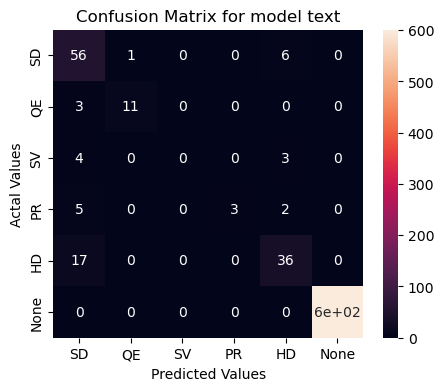

audio
              precision    recall  f1-score   support

          SD       0.84      0.86      0.85        63
          QE       0.93      0.93      0.93        14
          SV       0.00      0.00      0.00         8
          PR       1.00      0.58      0.74        12
          HD       0.80      0.85      0.83        62
        None       1.00      1.00      1.00       601

   micro avg       0.97      0.96      0.96       760
   macro avg       0.76      0.70      0.72       760
weighted avg       0.96      0.96      0.96       760
 samples avg       0.96      0.96      0.96       760



/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


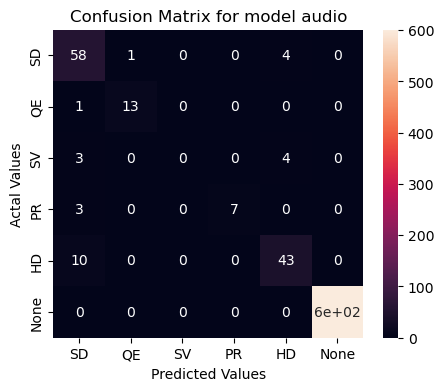

video
              precision    recall  f1-score   support

          SD       0.88      0.90      0.89        63
          QE       0.93      0.93      0.93        14
          SV       0.00      0.00      0.00         8
          PR       1.00      0.58      0.74        12
          HD       0.82      0.89      0.85        62
        None       1.00      1.00      1.00       601

   micro avg       0.97      0.96      0.97       760
   macro avg       0.77      0.72      0.73       760
weighted avg       0.96      0.96      0.96       760
 samples avg       0.97      0.97      0.97       760



/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


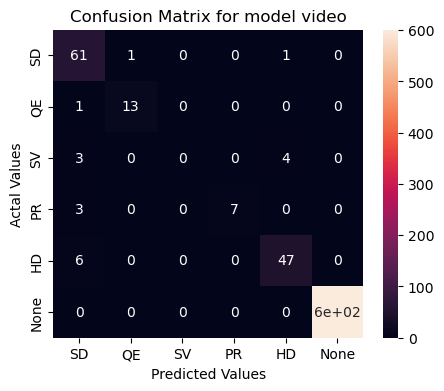

multimodal


/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          SD       0.75      0.14      0.24        63
          QE       0.00      0.00      0.00        14
          SV       0.00      0.00      0.00         8
          PR       0.00      0.00      0.00        12
          HD       0.00      0.00      0.00        62
        None       0.80      1.00      0.89       601

   micro avg       0.80      0.80      0.80       760
   macro avg       0.26      0.19      0.19       760
weighted avg       0.70      0.80      0.72       760
 samples avg       0.81      0.81      0.81       760



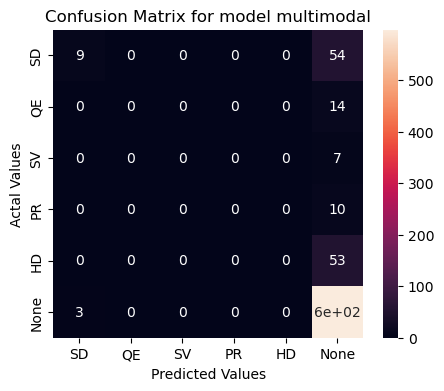

In [48]:
results = [txt_pred_n, audio_pred_n, video_pred_n, multimodal_pred_n]
names = ["text", "audio", "video", "multimodal"]

for pred, n in zip(results, names):
    pred_final = np.where(pred > .5, 1, 0)
    print(n)
    print(classification_report(y_true, pred_final, target_names = ['SD', 'QE', 'SV', 'PR', 'HD', "None"]))
    cm = confusion_matrix(np.argmax(y_true, axis = 1), np.argmax(pred_final, axis = 1))
    plt.figure(figsize=(5,4))
    cm_df = pd.DataFrame(cm,
                     index = ['SD', 'QE', 'SV', 'PR', 'HD', "None"], 
                     columns = ['SD', 'QE', 'SV', 'PR', 'HD', "None"])
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix for model {}'.format(n))
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()


In [42]:
print(np.argmax(y_true, axis = 1))

[5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 5 5 4 5 5 5 5 4 5 5 5 0
 0 5 2 5 5 5 0 4 5 5 0 5 0 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 4 5 3 5 5 5 5 5 5 4 5 5 5
 5 5 5 5 0 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 5 5 5 1 5 4 5 5
 4 5 5 5 5 5 5 5 0 5 4 5 5 5 2 5 5 5 0 5 0 3 5 5 5 0 4 5 1 1 5 5 5 5 4 5 5
 5 5 5 4 5 5 5 5 5 5 5 4 4 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 0 5 5 5 5 4 5
 5 0 5 5 5 5 0 5 5 5 0 5 5 5 5 2 5 0 5 5 5 0 5 5 5 0 5 5 5 5 5 5 5 5 5 5 5
 4 5 5 5 5 5 5 5 5 5 5 4 5 1 5 5 5 5 5 5 5 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0
 5 5 5 2 5 5 5 0 5 5 5 5 5 1 5 5 0 5 5 0 5 5 5 5 0 5 5 5 5 5 5 5 5 5 5 0 2
 5 5 0 5 4 5 5 5 5 5 5 5 5 0 2 5 5 0 5 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 0
 5 5 5 5 5 4 5 5 5 0 5 5 5 5 5 5 5 5 5 5 5 4 5 4 1 5 0 5 5 5 0 0 5 5 5 5 5
 0 5 1 5 5 5 5 5 4 1 5 5 0 0 5 5 4 5 5 5 5 0 5 0 5 0 5 5 0 5 5 5 5 5 5 5 5
 5 5 3 5 5 4 5 5 1 5 5 3 5 5 5 5 5 5 5 0 5 5 5 5 5 5 5 0 0 5 5 5 5 5 4 5 0
 5 5 5 5 4 5 5 5 5 5 5 5 